In [1]:
import pandas as pd
import cv2
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import warnings

from config import Config
from detector import MediaPipeProcessor

warnings.filterwarnings("ignore")

config = Config()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(42)
np.random.seed(42)

2025-07-21 14:33:46.361958: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-21 14:33:46.371980: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753083226.383829   16408 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753083226.387274   16408 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-21 14:33:46.400142: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
def load_labels_from_csv(csv_file=None):
    """Load labels from CSV file"""
    if csv_file is None:
        csv_file = config.data.input_csv_file
    
    df = pd.read_csv(csv_file)
    video_to_label_mapping = {}
    id_to_label_mapping = {}

    for _, row in df.iterrows():
        label_id = row['id']
        label_name = row['label']
        videos_str = row['videos']
        video_files = [v.strip() for v in videos_str.split(',')]

        id_to_label_mapping[label_id] = label_name
        
        for video_file in video_files:
            video_base = os.path.splitext(video_file)[0]
            video_to_label_mapping[video_base] = label_id
    
    unique_labels = sorted(df['id'].unique())
    label_to_idx = {label: idx for idx, label in enumerate(unique_labels)}
    
    print(f"[INFO] {len(unique_labels)} classes: {unique_labels}")
    print(f"[INFO] {len(video_to_label_mapping)} videos")
    
    return video_to_label_mapping, label_to_idx, unique_labels, id_to_label_mapping

# Load labels
video_to_label_mapping, label_to_idx, unique_labels, id_to_label_mapping = load_labels_from_csv()
num_classes = len(unique_labels)

[INFO] 15 classes: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
[INFO] 300 videos


In [3]:
def flip_keypoints(keypoints):
    """
    Flip keypoints horizontally for data augmentation
    Args:
        keypoints: numpy array of shape (T, V, C) where V=75 (33 pose + 21 left hand + 21 right hand)
    Returns:
        flipped_keypoints: horizontally flipped keypoints
    """
    flipped_keypoints = keypoints.copy()
    
    # Flip x coordinates (assuming x is the first channel)
    flipped_keypoints[:, :, 0] = 1.0 - flipped_keypoints[:, :, 0]
    
    # Define swap mappings for MediaPipe landmarks
    # Pose landmarks that need to be swapped (left <-> right)
    pose_swap_pairs = [
        (1, 4),   # left_eye_inner <-> right_eye_inner
        (2, 5),   # left_eye <-> right_eye  
        (3, 6),   # left_eye_outer <-> right_eye_outer
        (7, 8),   # left_ear <-> right_ear
        (11, 12), # left_shoulder <-> right_shoulder
        (13, 14), # left_elbow <-> right_elbow
        (15, 16), # left_wrist <-> right_wrist
        (17, 18), # left_pinky <-> right_pinky
        (19, 20), # left_index <-> right_index
        (21, 22), # left_thumb <-> right_thumb
        (23, 24), # left_hip <-> right_hip
        (25, 26), # left_knee <-> right_knee
        (27, 28), # left_ankle <-> right_ankle
        (29, 30), # left_heel <-> right_heel
        (31, 32)  # left_foot_index <-> right_foot_index
    ]
    
    # Swap pose landmarks
    for left_idx, right_idx in pose_swap_pairs:
        flipped_keypoints[:, left_idx, :], flipped_keypoints[:, right_idx, :] = \
            flipped_keypoints[:, right_idx, :].copy(), flipped_keypoints[:, left_idx, :].copy()
    
    # Swap left and right hand landmarks
    # Left hand (indices 33-53) <-> Right hand (indices 54-74)
    left_hand_start, left_hand_end = 33, 54
    right_hand_start, right_hand_end = 54, 75
    
    temp_left_hand = flipped_keypoints[:, left_hand_start:left_hand_end, :].copy()
    flipped_keypoints[:, left_hand_start:left_hand_end, :] = flipped_keypoints[:, right_hand_start:right_hand_end, :]
    flipped_keypoints[:, right_hand_start:right_hand_end, :] = temp_left_hand
    
    return flipped_keypoints

def transform_keypoints(keypoints, translation_range=0.1, scale_range=0.1):
    """
    Apply translation and scaling augmentation to keypoints
    Args:
        keypoints: numpy array of shape (T, V, C) where V=75, C=2 (x, y)
        translation_range: range for random translation (-range to +range)
        scale_range: range for random scaling (1-range to 1+range)
    Returns:
        transformed_keypoints: augmented keypoints
    """
    transformed_keypoints = keypoints.copy()
    
    # Random translation for x and y coordinates
    # Generate random translation values for the entire sequence
    tx = np.random.uniform(-translation_range, translation_range)
    ty = np.random.uniform(-translation_range, translation_range)
    
    # Apply translation
    transformed_keypoints[:, :, 0] += tx  # x coordinates
    transformed_keypoints[:, :, 1] += ty  # y coordinates
    
    # Random scaling
    # Generate random scale factors
    scale_x = np.random.uniform(1 - scale_range, 1 + scale_range)
    scale_y = np.random.uniform(1 - scale_range, 1 + scale_range)
    
    # Find the center of keypoints for scaling
    center_x = np.mean(transformed_keypoints[:, :, 0])
    center_y = np.mean(transformed_keypoints[:, :, 1])
    
    # Apply scaling around center
    transformed_keypoints[:, :, 0] = center_x + (transformed_keypoints[:, :, 0] - center_x) * scale_x
    transformed_keypoints[:, :, 1] = center_y + (transformed_keypoints[:, :, 1] - center_y) * scale_y
    
    # Clamp values to [0, 1] range (assuming normalized coordinates)
    transformed_keypoints = np.clip(transformed_keypoints, 0.0, 1.0)
    
    return transformed_keypoints

class SignLanguageDataset(Dataset):
    """Dataset for Sign Language Recognition with stratified split and multiple data augmentation options"""
    
    def __init__(self, keypoints_dir, video_to_label_mapping, label_to_idx, sequence_length=None, 
                 split_type='train', train_split=None, 
                 use_flip_augmentation=True, use_transform_augmentation=True, 
                 use_strategy=True):
        
        self.sequence_length = sequence_length or config.hgc_lstm.sequence_length
        train_split = train_split or config.training.train_split
        self.use_flip_augmentation = use_flip_augmentation
        self.use_transform_augmentation = use_transform_augmentation
        self.use_strategy = use_strategy
        
        # Get augmentation parameters from config
        self.translation_range = config.data.translation_range
        self.scale_range = config.data.scale_range
        
        self.keypoints_dir = keypoints_dir
        self.video_to_label_mapping = video_to_label_mapping
        self.label_to_idx = label_to_idx
        
        # Get all available files
        available_files = [f for f in os.listdir(keypoints_dir) if f.endswith(config.data.keypoints_ext)]
        valid_files = []
        for file in available_files:
            base_name = os.path.splitext(file)[0]
            if base_name in video_to_label_mapping:
                valid_files.append(base_name)
        
        if self.use_strategy:
            # Stratified split - ensure each class has balanced samples in train/val
            print(f"[INFO] Using stratified split strategy")
            
            # Group files by label_id for stratified split
            label_to_files = {}
            for file in valid_files:
                label_id = video_to_label_mapping[file]
                if label_id not in label_to_files:
                    label_to_files[label_id] = []
                label_to_files[label_id].append(file)
            
            # Perform stratified split
            train_files = []
            val_files = []
            
            for label_id, files in label_to_files.items():
                # Shuffle files for this class
                np.random.shuffle(files)
                
                # Calculate split for this class
                n_files = len(files)
                n_train = int(n_files * train_split)
                n_val = n_files - n_train
                
                # Split files for this class
                class_train = files[:n_train]
                class_val = files[n_train:]
                
                train_files.extend(class_train)
                val_files.extend(class_val)
            
            # Shuffle the final lists
            np.random.shuffle(train_files)
            np.random.shuffle(val_files)
        else:
            # Simple random split - no stratification
            print(f"[INFO] Using simple random split")
            
            # Shuffle all files
            np.random.shuffle(valid_files)
            
            # Calculate split point
            n_total = len(valid_files)
            n_train = int(n_total * train_split)
            
            # Split files
            train_files = valid_files[:n_train]
            val_files = valid_files[n_train:]
        
        # Select files based on split type
        if split_type == 'train':
            self.files = train_files
        else:
            self.files = val_files
        
        # Calculate total samples with augmentation
        self.original_samples = len(self.files)
        augmentation_multiplier = 1
        
        if self.use_flip_augmentation:
            augmentation_multiplier += 1  # +1 for flipped versions
        if self.use_transform_augmentation:
            augmentation_multiplier += 1  # +1 for transformed versions
        if self.use_flip_augmentation and self.use_transform_augmentation:
            augmentation_multiplier += 1  # +1 for flip + transform combined
        
        # Create augmented file indices
        self.augmented_samples = self.original_samples * augmentation_multiplier
        
        print(f"[INFO] {split_type.upper()} dataset: {self.original_samples} original files")
        if self.use_flip_augmentation or self.use_transform_augmentation:
            print(f"[INFO] Augmentation enabled: {self.augmented_samples} total samples (x{augmentation_multiplier})")
            print(f"  - Flip augmentation: {'✓' if self.use_flip_augmentation else '✗'}")
            print(f"  - Transform augmentation: {'✓' if self.use_transform_augmentation else '✗'}")
        
        # Print class distribution for verification
        self._print_class_distribution(split_type)

    def _print_class_distribution(self, split_type):
        """Print class distribution to verify balanced split"""
        class_counts = {}
        for file in self.files:
            label_id = self.video_to_label_mapping[file]
            class_counts[label_id] = class_counts.get(label_id, 0) + 1
        
        print(f"[INFO] {split_type.upper()} class distribution:")
        for label_id, count in sorted(class_counts.items()):
            print(f"  Class {label_id}: {count} samples")

        counts = list(class_counts.values())
        if len(set(counts)) != 1:
            min_count, max_count = min(counts), max(counts)
            print(f"[INFO] ⚠ Imbalanced: {min_count}-{max_count} samples per class")
        else:
            print(f"[INFO] ✓ Balanced: {counts[0]} samples per class")

    def __len__(self):
        return self.augmented_samples

    def __getitem__(self, idx):
        # Determine augmentation type based on index
        file_idx = idx % self.original_samples
        augmentation_type = idx // self.original_samples
        
        base_filename = self.files[file_idx]
        
        kp_path = os.path.join(self.keypoints_dir, f"{base_filename}{config.data.keypoints_ext}")
        kp_sequence = np.load(kp_path)
        
        if len(kp_sequence.shape) == 2:
            T, features = kp_sequence.shape
            expected_features = config.hgc_lstm.num_vertices * config.hgc_lstm.in_channels
            if features == expected_features:
                kp_sequence = kp_sequence.reshape(T, config.hgc_lstm.num_vertices, config.hgc_lstm.in_channels)
        
        # Apply augmentations based on augmentation_type
        if augmentation_type == 0:
            # Original - no augmentation
            pass
        elif augmentation_type == 1 and self.use_flip_augmentation:
            # Flip only
            kp_sequence = flip_keypoints(kp_sequence)
        elif augmentation_type == 1 and self.use_transform_augmentation and not self.use_flip_augmentation:
            # Transform only (when flip is disabled)
            kp_sequence = transform_keypoints(kp_sequence, self.translation_range, self.scale_range)
        elif augmentation_type == 2 and self.use_transform_augmentation:
            # Transform only (when flip is enabled)
            kp_sequence = transform_keypoints(kp_sequence, self.translation_range, self.scale_range)
        elif augmentation_type == 3 and self.use_flip_augmentation and self.use_transform_augmentation:
            # Both flip and transform
            kp_sequence = flip_keypoints(kp_sequence)
            kp_sequence = transform_keypoints(kp_sequence, self.translation_range, self.scale_range)
        
        label_id = self.video_to_label_mapping[base_filename]
        label_idx = self.label_to_idx[label_id]
        
        return torch.from_numpy(kp_sequence).float(), torch.tensor(label_idx, dtype=torch.long)

In [4]:
# Create datasets with stratified split and augmentation
print("[INFO] Creating datasets...")
keypoints_dir = config.data.keypoints_output_dir

# Set random seed for reproducible splits
np.random.seed(42)

# Get parameters from config
use_strategy = config.data.use_strategy
use_flip_augmentation = config.data.use_flip_augmentation
use_transform_augmentation = config.data.use_transform_augmentation

# Training uses augmentation, validation does not (for fair evaluation)
use_train_flip = use_flip_augmentation
use_train_transform = use_transform_augmentation
use_val_flip = False
use_val_transform = False

print(f"[INFO] Configuration:")
print(f"  - Split strategy: {'Stratified' if use_strategy else 'Random'}")
print(f"  - Train flip augmentation: {'Enabled' if use_train_flip else 'Disabled'}")
print(f"  - Train transform augmentation: {'Enabled' if use_train_transform else 'Disabled'}")
print(f"  - Translation range: ±{config.data.translation_range}")
print(f"  - Scale range: ±{config.data.scale_range}")
print(f"  - Val augmentation: Disabled (for fair evaluation)")

train_dataset = SignLanguageDataset(
    keypoints_dir, video_to_label_mapping, label_to_idx, 
    split_type='train', 
    use_flip_augmentation=use_train_flip, 
    use_transform_augmentation=use_train_transform,
    use_strategy=use_strategy
)

val_dataset = SignLanguageDataset(
    keypoints_dir, video_to_label_mapping, label_to_idx, 
    split_type='val', 
    use_flip_augmentation=use_val_flip, 
    use_transform_augmentation=use_val_transform,
    use_strategy=use_strategy
)

print(f"\n[INFO] Dataset summary:")
print(f"  Total classes: {len(unique_labels)}")
print(f"  Train samples: {len(train_dataset)}")
print(f"  Val samples: {len(val_dataset)}")
print(f"  Strategy: {'Stratified' if use_strategy else 'Random'} split")

[INFO] Creating datasets...
[INFO] Configuration:
  - Split strategy: Stratified
  - Train flip augmentation: Disabled
  - Train transform augmentation: Enabled
  - Translation range: ±0.1
  - Scale range: ±0.1
  - Val augmentation: Disabled (for fair evaluation)
[INFO] Using stratified split strategy
[INFO] TRAIN dataset: 240 original files
[INFO] Augmentation enabled: 480 total samples (x2)
  - Flip augmentation: ✗
  - Transform augmentation: ✓
[INFO] TRAIN class distribution:
  Class 1: 16 samples
  Class 2: 16 samples
  Class 3: 16 samples
  Class 4: 16 samples
  Class 5: 16 samples
  Class 6: 16 samples
  Class 7: 16 samples
  Class 8: 16 samples
  Class 9: 16 samples
  Class 10: 16 samples
  Class 11: 16 samples
  Class 12: 16 samples
  Class 13: 16 samples
  Class 14: 16 samples
  Class 15: 16 samples
[INFO] ✓ Balanced: 16 samples per class
[INFO] Using stratified split strategy
[INFO] VAL dataset: 60 original files
[INFO] VAL class distribution:
  Class 1: 4 samples
  Class 2: 

In [5]:
def create_data_loaders(train_dataset, val_dataset, batch_size=None):
    """Create data loaders"""
    batch_size = batch_size or config.training.batch_size
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    print(f"[INFO] Train batches: {len(train_loader)}")
    print(f"[INFO] Valid batches: {len(val_loader)}")
    print(f"[INFO] Batch size: {batch_size}")
    
    # Show detailed augmentation info
    if hasattr(train_dataset, 'use_flip_augmentation') or hasattr(train_dataset, 'use_transform_augmentation'):
        original_samples = train_dataset.original_samples
        total_samples = len(train_dataset)
        
        augmentations = []
        if hasattr(train_dataset, 'use_flip_augmentation') and train_dataset.use_flip_augmentation:
            augmentations.append("Flip")
        if hasattr(train_dataset, 'use_transform_augmentation') and train_dataset.use_transform_augmentation:
            augmentations.append("Transform")
        
        if augmentations:
            aug_str = " + ".join(augmentations)
            print(f"[INFO] Data Augmentation ({aug_str}): {original_samples} original → {total_samples} total samples")
        else:
            print(f"[INFO] No augmentation: {total_samples} samples")
    
    sample_kp, sample_lbl = next(iter(train_loader))
    print(f"[INFO] Sample keypoints shape: {sample_kp.shape}")  # (B, T, V, C)
    print(f"[INFO] Sample labels shape: {sample_lbl.shape}")    # (B,)
    return train_loader, val_loader

# Create data loaders
print("\n[INFO] Creating data loaders...")
train_loader, val_loader = create_data_loaders(train_dataset, val_dataset)


[INFO] Creating data loaders...
[INFO] Train batches: 60
[INFO] Valid batches: 8
[INFO] Batch size: 8
[INFO] Data Augmentation (Transform): 240 original → 480 total samples
[INFO] Sample keypoints shape: torch.Size([8, 60, 75, 2])
[INFO] Sample labels shape: torch.Size([8])


In [6]:
def create_adjacency_matrix(num_vertices=None):
    """Create adjacency matrix for skeleton graph"""
    N = num_vertices or config.hgc_lstm.num_vertices
    A = np.zeros((N, N), dtype=np.float32)
    
    # MediaPipe connections for pose (33 points)
    POSE_CONNECTIONS = [
        (0, 1), (1, 2), (2, 3), (3, 7), (0, 4), (4, 5), (5, 6), (6, 8),
        (9, 10), (11, 12), (11, 13), (13, 15), (15, 17), (15, 19), (15, 21),
        (17, 19), (12, 14), (14, 16), (16, 18), (16, 20), (16, 22), (18, 20),
        (11, 23), (12, 24), (23, 24), (23, 25), (24, 26), (25, 27), (26, 28),
        (27, 29), (28, 30), (29, 31), (30, 32), (27, 31), (28, 32)
    ]
    
    # Hand connections (21 points each)
    HAND_CONNECTIONS = [
        (0, 1), (1, 2), (2, 3), (3, 4), 
        (0, 5), (5, 6), (6, 7), (7, 8), 
        (0, 9), (9, 10), (10, 11), (11, 12), 
        (0, 13), (13, 14), (14, 15), (15, 16),  
        (0, 17), (17, 18), (18, 19), (19, 20), 
        (5, 9), (9, 13), (13, 17) 
    ]

    for i, j in POSE_CONNECTIONS:
        if i < 33 and j < 33:
            A[i, j] = 1
            A[j, i] = 1

    for i, j in HAND_CONNECTIONS:
        u, v = i + 33, j + 33
        if u < N and v < N:
            A[u, v] = 1
            A[v, u] = 1

    for i, j in HAND_CONNECTIONS:
        u, v = i + 54, j + 54
        if u < N and v < N:
            A[u, v] = 1
            A[v, u] = 1

    np.fill_diagonal(A, 1)

    D = np.diag(np.sum(A, axis=1) ** -0.5)
    A_norm = D @ A @ D
    
    return torch.tensor(A_norm, dtype=torch.float32)

A = create_adjacency_matrix()
print(f"[INFO] Adjacency matrix shape: {A.shape}")
print(f"[INFO] Number of vertices: {config.hgc_lstm.num_vertices}")

[INFO] Adjacency matrix shape: torch.Size([75, 75])
[INFO] Number of vertices: 75


In [7]:
class GCNLayer(nn.Module):
    """Graph Convolutional Layer"""
    def __init__(self, in_features, out_features, A, use_batch_norm=True):
        super(GCNLayer, self).__init__()
        self.A = A
        self.fc = nn.Linear(in_features, out_features)
        self.use_batch_norm = use_batch_norm
        if use_batch_norm:
            self.bn = nn.BatchNorm1d(out_features)

    def forward(self, x):
        # x: (B, T, V, C)
        B, T, V, C = x.size()
        x = x.reshape(B * T, V, C)  # (B*T, V, C)
        A = self.A.to(x.device)
        x = torch.matmul(A, x)   # (B*T, V, C)
        x = self.fc(x)           # (B*T, V, out_features)
        x = x.reshape(B, T, V, -1)  # (B, T, V, out_features)
        
        if self.use_batch_norm:
            x = x.permute(0, 3, 1, 2)  # (B, out_features, T, V)
            x = self.bn(x.contiguous().view(B, -1, T * V))  # Batch norm
            x = x.view(B, -1, T, V).permute(0, 2, 3, 1)  # Back to (B, T, V, out_features)
        
        return F.relu(x)

class AttentionPooling(nn.Module):
    """Attention-based pooling over joints dimension"""
    def __init__(self, hidden_dim, dropout=0.1):
        super(AttentionPooling, self).__init__()
        self.attention = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        # x: (B, T, V, H)
        B, T, V, H = x.shape
        
        # Compute attention weights
        att_scores = self.attention(x)  # (B, T, V, 1)
        att_weights = F.softmax(att_scores, dim=2)  # Normalize over joints
        
        # Apply dropout to attention weights
        att_weights = self.dropout(att_weights)
        
        # Weighted sum over joints
        output = torch.sum(x * att_weights, dim=2)  # (B, T, H)
        
        return output, att_weights

class HGC_LSTM(nn.Module):
    """Hierarchical Graph Convolution + LSTM"""
    def __init__(self, config, A, num_classes):
        super(HGC_LSTM, self).__init__()
        self.config = config
        
        # Build GCN layers
        self.gcn_layers = nn.ModuleList()
        for i in range(config.hgc_lstm.gcn_layers):
            if i == 0:
                in_features = config.hgc_lstm.in_channels
            else:
                in_features = config.hgc_lstm.hidden_gcn
            
            self.gcn_layers.append(
                GCNLayer(in_features, config.hgc_lstm.hidden_gcn, A, config.hgc_lstm.use_batch_norm)
            )
        
        # Pooling layer
        if config.hgc_lstm.pooling_type == "adaptive_avg":
            self.pool = nn.AdaptiveAvgPool2d((None, 1))
            self.use_attention = False
        elif config.hgc_lstm.pooling_type == "adaptive_max":
            self.pool = nn.AdaptiveMaxPool2d((None, 1))
            self.use_attention = False
        elif config.hgc_lstm.pooling_type == "attention":
            self.pool = AttentionPooling(config.hgc_lstm.hidden_gcn, config.hgc_lstm.dropout)
            self.use_attention = True
        else:
            self.pool = nn.AdaptiveAvgPool2d((None, 1))  # Default
            self.use_attention = False
        
        # LSTM layer
        self.lstm = nn.LSTM(
            config.hgc_lstm.hidden_gcn, 
            config.hgc_lstm.hidden_lstm, 
            num_layers=config.hgc_lstm.lstm_layers,
            batch_first=True, 
            bidirectional=config.hgc_lstm.lstm_bidirectional
        )
        
        # Adjust output size for bidirectional LSTM
        lstm_output_size = config.hgc_lstm.hidden_lstm * (2 if config.hgc_lstm.lstm_bidirectional else 1)
        
        self.dropout = nn.Dropout(config.hgc_lstm.dropout)
        self.fc = nn.Linear(lstm_output_size, num_classes)

    def forward(self, x):
        # x: (B, T, V, C)
        for gcn_layer in self.gcn_layers:
            x = gcn_layer(x)  # (B, T, V, H)
        
        # Pool over joints dimension
        if self.use_attention:
            x, att_weights = self.pool(x)  # (B, T, H)
        else:
            x = x.permute(0, 3, 1, 2)  # (B, H, T, V)
            x = self.pool(x).squeeze(-1)  # (B, H, T)
            x = x.permute(0, 2, 1)  # (B, T, H)
        
        # LSTM processing
        self.lstm.flatten_parameters()
        x, _ = self.lstm(x)  # (B, T, H_lstm)
        x = x[:, -1]  # Take last time step
        x = self.dropout(x)
        x = self.fc(x)  # (B, num_classes)
        return x

# Create model
model = HGC_LSTM(config, A, num_classes)
model.to(device)

print(f"[INFO] Model created with {sum(p.numel() for p in model.parameters())} parameters")
print(f"[INFO] Model configuration:")
print(f"  - GCN layers: {config.hgc_lstm.gcn_layers}")
print(f"  - GCN hidden dim: {config.hgc_lstm.hidden_gcn}")
print(f"  - LSTM hidden dim: {config.hgc_lstm.hidden_lstm}")
print(f"  - LSTM layers: {config.hgc_lstm.lstm_layers}")
print(f"  - Bidirectional: {config.hgc_lstm.lstm_bidirectional}")
print(f"  - Dropout: {config.hgc_lstm.dropout}")
print(f"  - Pooling type: {config.hgc_lstm.pooling_type}")
print(f"  - Sequence length: {config.hgc_lstm.sequence_length}")
print(f"  - Number of vertices: {config.hgc_lstm.num_vertices}")

if config.hgc_lstm.pooling_type == "attention":
    print(f"  - Using Attention Pooling with dropout: {config.hgc_lstm.dropout}")
    print(f"  - Attention weights can be visualized after forward pass")

[INFO] Model created with 285584 parameters
[INFO] Model configuration:
  - GCN layers: 2
  - GCN hidden dim: 128
  - LSTM hidden dim: 128
  - LSTM layers: 1
  - Bidirectional: True
  - Dropout: 0.5
  - Pooling type: attention
  - Sequence length: 60
  - Number of vertices: 75
  - Using Attention Pooling with dropout: 0.5
  - Attention weights can be visualized after forward pass


In [8]:
def train_model(model, train_loader, val_loader, config, device):
    """Train the HGC-LSTM model"""
    criterion = nn.CrossEntropyLoss()
    
    # Setup optimizer
    if config.training.optimizer == "adam":
        optimizer = torch.optim.Adam(
            model.parameters(), 
            lr=config.training.learning_rate, 
            weight_decay=config.training.weight_decay
        )
    else:  # SGD
        optimizer = torch.optim.SGD(
            model.parameters(), 
            lr=config.training.learning_rate, 
            weight_decay=config.training.weight_decay,
            momentum=config.training.momentum
        )
    
    # Setup scheduler
    if config.training.scheduler == "step":
        scheduler = torch.optim.lr_scheduler.StepLR(
            optimizer, 
            step_size=config.training.scheduler_step_size, 
            gamma=config.training.scheduler_gamma
        )
    elif config.training.scheduler == "cosine":
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer, 
            T_max=config.training.num_epochs
        )
    else:
        scheduler = None
    
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    best_val_acc = 0.0
    patience_counter = 0
    
    # Create save directory
    os.makedirs(config.training.save_dir, exist_ok=True)
    
    for epoch in range(config.training.num_epochs):
        # Training
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        for batch_idx, (keypoints, labels) in enumerate(train_loader):
            keypoints, labels = keypoints.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(keypoints)
            loss = criterion(outputs, labels)
            loss.backward()
            
            # Gradient clipping
            if config.training.gradient_clip_norm > 0:
                torch.nn.utils.clip_grad_norm_(model.parameters(), config.training.gradient_clip_norm)
            
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
        
        # Validation
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for keypoints, labels in val_loader:
                keypoints, labels = keypoints.to(device), labels.to(device)
                outputs = model(keypoints)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        # Calculate metrics
        train_loss = train_loss / len(train_loader)
        val_loss = val_loss / len(val_loader)
        train_acc = 100. * train_correct / train_total
        val_acc = 100. * val_correct / val_total
        
        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            model_path = os.path.join(config.training.save_dir, config.training.model_save_name)
            torch.save(model.state_dict(), model_path)
        else:
            patience_counter += 1
        
        # Store metrics
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        
        # Update learning rate
        if scheduler is not None:
            scheduler.step()
        
        # Print progress
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch+1:03d}/{config.training.num_epochs} | Train Loss: {train_loss:.4f} Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f} Acc: {val_acc:.2f}% | LR: {current_lr:.6f}")
        # Early stopping
        if patience_counter >= config.training.early_stopping_patience:
            print(f"[INFO] Early stopping triggered after {epoch+1} epochs")
            break
    
    print(f"[INFO] Training completed. Best validation accuracy: {best_val_acc:.2f}%")
    return history

In [9]:
print("[INFO] Starting training...")
print(f"[INFO] Training configuration:")
print(f"  - Epochs: {config.training.num_epochs}")
print(f"  - Batch size: {config.training.batch_size}")
print(f"  - Learning rate: {config.training.learning_rate}")
print(f"  - Optimizer: {config.training.optimizer}")
print(f"  - Scheduler: {config.training.scheduler}")
print(f"  - Early stopping patience: {config.training.early_stopping_patience}")
history = train_model(model, train_loader, val_loader, config, device)

[INFO] Starting training...
[INFO] Training configuration:
  - Epochs: 300
  - Batch size: 8
  - Learning rate: 0.001
  - Optimizer: adam
  - Scheduler: step
  - Early stopping patience: 100
Epoch 001/300 | Train Loss: 2.7382 Acc: 5.62% | Val Loss: 2.7116 Acc: 6.67% | LR: 0.001000
Epoch 001/300 | Train Loss: 2.7382 Acc: 5.62% | Val Loss: 2.7116 Acc: 6.67% | LR: 0.001000
Epoch 002/300 | Train Loss: 2.7226 Acc: 6.46% | Val Loss: 2.7121 Acc: 10.00% | LR: 0.001000
Epoch 002/300 | Train Loss: 2.7226 Acc: 6.46% | Val Loss: 2.7121 Acc: 10.00% | LR: 0.001000
Epoch 003/300 | Train Loss: 2.7203 Acc: 8.33% | Val Loss: 2.7173 Acc: 5.00% | LR: 0.001000
Epoch 003/300 | Train Loss: 2.7203 Acc: 8.33% | Val Loss: 2.7173 Acc: 5.00% | LR: 0.001000
Epoch 004/300 | Train Loss: 2.7162 Acc: 6.88% | Val Loss: 2.7100 Acc: 8.33% | LR: 0.001000
Epoch 004/300 | Train Loss: 2.7162 Acc: 6.88% | Val Loss: 2.7100 Acc: 8.33% | LR: 0.001000
Epoch 005/300 | Train Loss: 2.7127 Acc: 6.25% | Val Loss: 2.7152 Acc: 3.33% | L

# Training Process Visualization

This section provides essential visualization of the training process including:
- **Loss curves**: Training and validation loss over epochs
- **Accuracy curves**: Training and validation accuracy over epochs  
- **Confusion matrix**: Model performance analysis on validation set

[INFO] Generating training process visualization...
[INFO] Training curves saved to: training_plots/training_curves.png


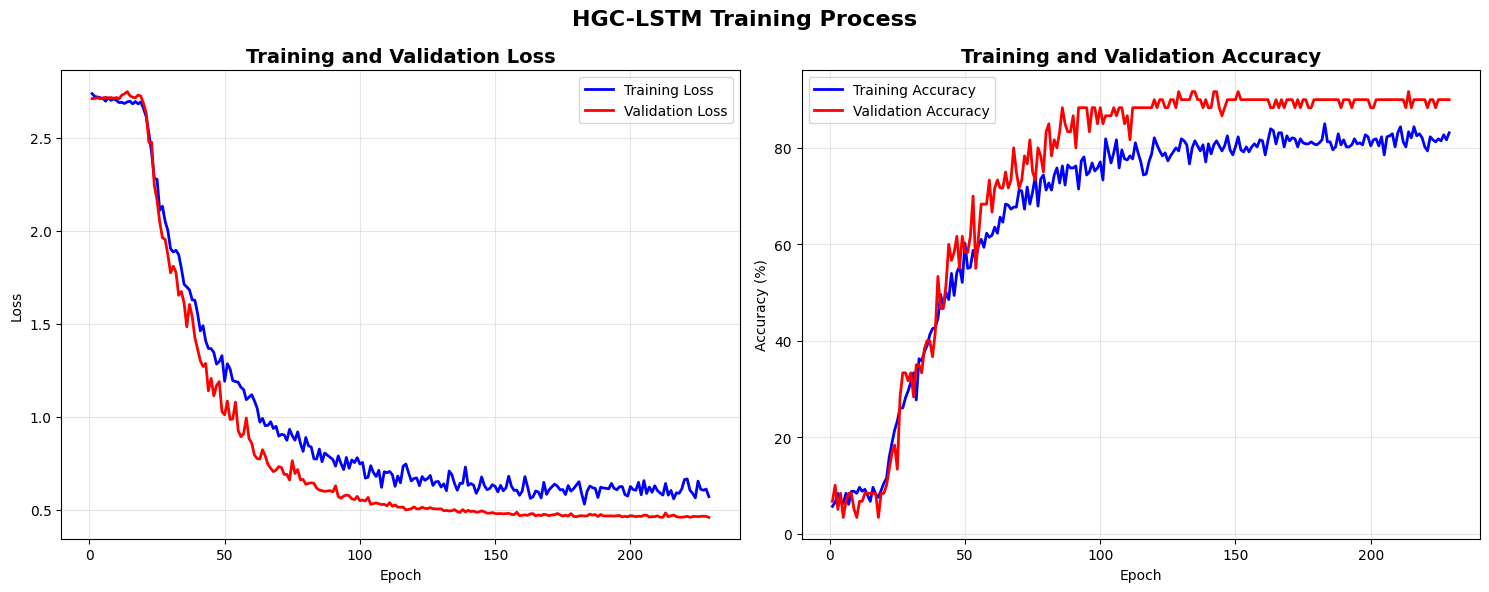


📊 TRAINING SUMMARY:
   Best Validation Accuracy: 91.67% (Epoch 129)
   Final Training Accuracy: 83.12%
   Final Validation Accuracy: 90.00%


In [ ]:
def visualize_training_process(history, config, save_plots=True):
    """
    Simple visualization of training process - only essential plots
    Args:
        history: training history dict with train_loss, val_loss, train_acc, val_acc
        config: configuration object
        save_plots: whether to save plots to disk
    """
    import matplotlib.pyplot as plt
    import numpy as np
    from pathlib import Path
    
    # Create plots directory
    plots_dir = Path("training_plots")
    plots_dir.mkdir(exist_ok=True)
    
    # Extract data
    epochs = range(1, len(history['train_loss']) + 1)
    train_losses = history['train_loss']
    val_losses = history['val_loss']
    train_accs = history['train_acc']
    val_accs = history['val_acc']
    
    # Create simple figure with 2 plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # 1. Loss curves
    ax1.plot(epochs, train_losses, 'b-', label='Training Loss', linewidth=1)
    ax1.plot(epochs, val_losses, 'r-', label='Validation Loss', linewidth=1)
    ax1.set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Accuracy curves
    ax2.plot(epochs, train_accs, 'b-', label='Training Accuracy', linewidth=1)
    ax2.plot(epochs, val_accs, 'r-', label='Validation Accuracy', linewidth=1)
    ax2.set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.suptitle('HGC-LSTM Training Process', fontsize=16, fontweight='bold')
    plt.tight_layout()
    
    # Save plot
    if save_plots:
        plot_path = plots_dir / "training_curves.png"
        plt.savefig(plot_path, dpi=300, bbox_inches='tight', facecolor='white')
    
    plt.show()
    
    return fig
training_fig = visualize_training_process(history, config, save_plots=True)

[INFO] Analyzing model performance...
[INFO] Analyzing model performance on validation set...
[INFO] Confusion matrix saved to: training_plots/confusion_matrix.png


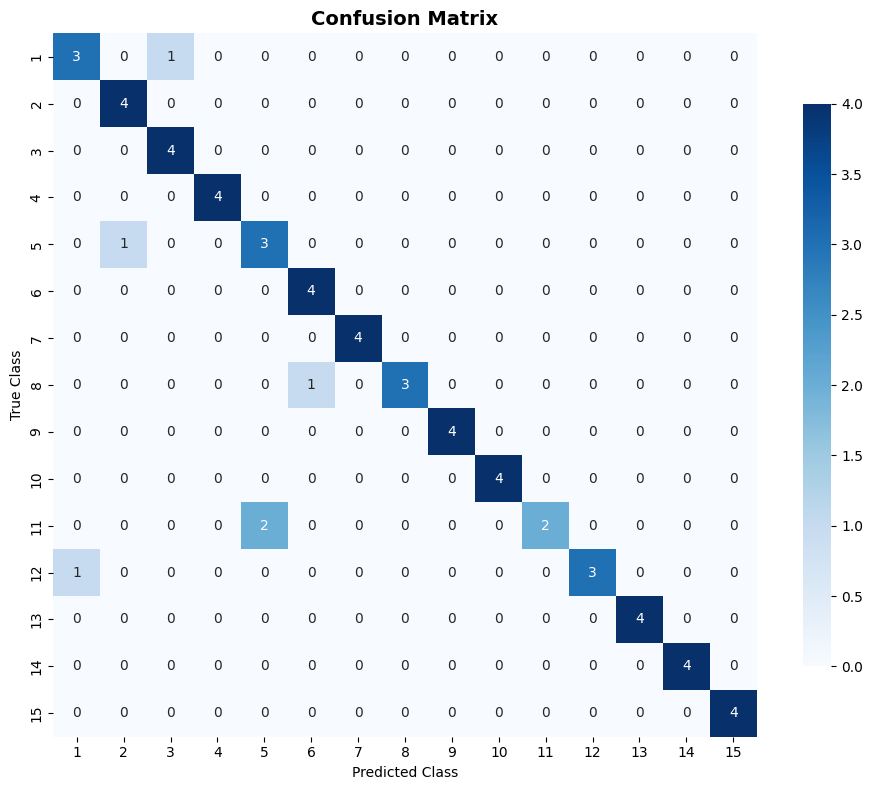


CLASSIFICATION REPORT
              precision    recall  f1-score   support

     Class_1       0.75      0.75      0.75         4
     Class_2       0.80      1.00      0.89         4
     Class_3       0.80      1.00      0.89         4
     Class_4       1.00      1.00      1.00         4
     Class_5       0.60      0.75      0.67         4
     Class_6       0.80      1.00      0.89         4
     Class_7       1.00      1.00      1.00         4
     Class_8       1.00      0.75      0.86         4
     Class_9       1.00      1.00      1.00         4
    Class_10       1.00      1.00      1.00         4
    Class_11       1.00      0.50      0.67         4
    Class_12       1.00      0.75      0.86         4
    Class_13       1.00      1.00      1.00         4
    Class_14       1.00      1.00      1.00         4
    Class_15       1.00      1.00      1.00         4

    accuracy                           0.90        60
   macro avg       0.92      0.90      0.90        60
wei

In [11]:
def analyze_model_performance(model, val_loader, device, config, unique_labels, id_to_label_mapping):
    """
    Simple model performance analysis - only confusion matrix
    Args:
        model: trained model
        val_loader: validation data loader
        device: computation device
        config: configuration object
        unique_labels: list of unique label IDs
        id_to_label_mapping: mapping from ID to label name
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np
    from sklearn.metrics import confusion_matrix, classification_report
    from pathlib import Path
    
    print("[INFO] Analyzing model performance on validation set...")
    
    # Create plots directory
    plots_dir = Path("training_plots")
    plots_dir.mkdir(exist_ok=True)
    
    model.eval()
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for keypoints, labels in val_loader:
            keypoints, labels = keypoints.to(device), labels.to(device)
            outputs = model(keypoints)
            _, predicted = torch.max(outputs, 1)
            
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    all_predictions = np.array(all_predictions)
    all_labels = np.array(all_labels)
    
    # Calculate metrics
    from sklearn.metrics import accuracy_score, precision_recall_fscore_support
    accuracy = accuracy_score(all_labels, all_predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_predictions, average='weighted')
    
    # Create confusion matrix plot
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    
    cm = confusion_matrix(all_labels, all_predictions)
    
    # Create label names for display
    label_names = []
    for label_idx in range(len(unique_labels)):
        label_id = unique_labels[label_idx]
        label_name = id_to_label_mapping.get(label_id, f"Class_{label_id}")
        label_names.append(f"{label_id}")  # Keep it simple for readability
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=label_names, yticklabels=label_names,
                square=True, cbar_kws={'shrink': 0.8}, ax=ax)
    ax.set_title('Confusion Matrix', fontsize=14, fontweight='bold')
    ax.set_xlabel('Predicted Class')
    ax.set_ylabel('True Class')
    
    plt.tight_layout()
    
    # Save plot
    confusion_path = plots_dir / "confusion_matrix.png"
    plt.savefig(confusion_path, dpi=300, bbox_inches='tight', facecolor='white')
    print(f"[INFO] Confusion matrix saved to: {confusion_path}")
    
    plt.show()
    
    # Print classification report
    print("\n" + "="*60)
    print("CLASSIFICATION REPORT")
    print("="*60)
    
    # Create class name mapping for report
    target_names = [f"Class_{uid}" for uid in unique_labels]
    print(classification_report(all_labels, all_predictions, target_names=target_names))
    
    print(f"\n📊 PERFORMANCE SUMMARY:")
    print(f"   Overall Accuracy: {accuracy*100:.2f}%")
    print(f"   Precision: {precision:.3f}")
    print(f"   Recall: {recall:.3f}")
    print(f"   F1-Score: {f1:.3f}")
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'confusion_matrix': cm,
        'predictions': all_predictions,
        'labels': all_labels
    }

# Analyze model performance
print("[INFO] Analyzing model performance...")
performance_results = analyze_model_performance(model, val_loader, device, config, unique_labels, id_to_label_mapping)

## Training Complete! 🎉

### Essential Visualization Summary

The HGC-LSTM model training has been completed with simplified, essential visualizations:

1. **Training/Validation Curves** - Loss and accuracy progression over epochs
2. **Confusion Matrix** - Model performance analysis on validation set

### Key Features Implemented

- ✅ **Multiple Augmentation Types**: Flip and Transform augmentations (configurable)
- ✅ **Stratified Dataset Split**: Balanced class distribution in train/val sets
- ✅ **Essential Analytics**: Clean training curves and confusion matrix

### Files Generated

- `training_plots/training_curves.png` - Training and validation loss/accuracy curves
- `training_plots/confusion_matrix.png` - Model performance confusion matrix
- `models/best_hgc_lstm_*.pth` - Saved best model weights

The visualization has been simplified to focus on the most important metrics for understanding model performance and training progress.